# Clinical Deterioration Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on clinical data to understand patterns related to patient deterioration. The analysis focuses on identifying risk factors and visualizing relationships between clinical variables and deterioration outcomes.

## Data Connection Setup
Import required libraries and establish database connection using the custom connector class.

In [1]:
# imports per postgres del pzero

import json
#from sshtunnel import SSHTunnelForwarder
#from sqlalchemy.orm import sessionmaker
#from sqlalchemy import create_engine
import sys
#from sqlalchemy import inspect
import pandas as pd
import os
import sys

ROOT_PATH = "/Users/xaviborrat/Documents/GitHub/TFM_Clinical_Deterioration"

sys.path.append(ROOT_PATH)
#importació llibreria de classes de connexio
import classes
from classes.xavi_con_class import db_connect as xcc

## Load Database Configuration
Create database connection using configuration file.

In [2]:
config_path = os.path.join(ROOT_PATH, 'classes/config_tfm.json')
with open(config_path, 'r') as configDnx:
    configDnx = json.load(configDnx)

datanex= xcc(
    ssh = configDnx["ssh"],
    ssh_user = configDnx["ssh_user"],
    ssh_host = configDnx["ssh_host"],
    ssh_pkey = configDnx["ssh_pkey"],
    db_host = configDnx["db_host"],
    db_port = configDnx["db_port"],
    db_user = configDnx["db_user"],
    db_pass = configDnx["db_pass"],
    flavour = configDnx["flavour"],
    db = configDnx["db"]
)

## Data Extraction
Query and prepare the clinical data tables for analysis:
- Ward stays (demographics and administrative data)
- Vital signs (numeric and text values)
- Laboratory results

All tables share a common structure: stay_id, concept, value, timestamp.

In [ ]:
# Preparació de les 4 taules per concatenar: WS, labs i vitals (num i text).
# Totes les taules tenen la mateixa estructura: stay_id, concept, value, timestamp.
# estructura final: stay_id, concept, value, timestamp.

# ward stay (capturem edat) ho fem a la taula ward_stays_ds perque te age_on_admission.
# A WS Filtrem només stays a WARD i que l'estança de l'stay sigui superior a stay_min.
stay_min = 48


# A la resta de taules filtrem per stay_id que estigui a la taula de ward_stays_ds.
ws = datanex.query('borrat_project',f"""
                    SELECT stay_id,
                        'age' AS concept,
                        age_on_admission AS value,
                        start_date AS time_stamp
                    FROM ward_stays_ds
                    WHERE care_level_type_ref = 'WARD'
                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}
                    UNION ALL
                    SELECT stay_id,
                        'medical_unit'  AS concept,
                        ou_med_ref      AS value,
                        start_date      AS time_stamp
                    FROM ward_stays_ds
                    WHERE care_level_type_ref = 'WARD'
                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}
                    UNION ALL
                    SELECT stay_id,
                        'stay_length' as concept,
                        TIMESTAMPDIFF(HOUR, start_date, end_date) AS value,
                        start_date AS time_stamp
                        FROM ward_stays_ds
                    WHERE care_level_type_ref = 'WARD'
                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}
                    UNION ALL
                    SELECT wsd.stay_id,
                        'sex' AS concept,
                        dd.sex AS value,
                        wsd.start_date AS time_stamp
                    FROM 
                    demographics_ds dd
                    JOIN 
                    ward_stays_ds wsd 
                    ON 
                    dd.patient_ref = wsd.patient_ref
                    WHERE wsd.care_level_type_ref = 'WARD'
                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}

                    ;""")

vitals_numerics = datanex.query('borrat_project',f"""select stay_id, rc_sap_ref as concept, result_num as value, result_date as time_stamp 
                                from vitals_ds
                                where rc_sap_ref in (
                                'FC',
                                'P_ART_S',
                                'TEMP',
                                'PULSIOX',
                                -- 'GLIC_CAPIL',
                                'FR',
                                'NEWS_2'
                                )
                                and stay_id in(
                                select stay_id
                                from borrat_project.ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

vitals_text = datanex.query('borrat_project',f"""select stay_id, rc_sap_ref as concept, result_txt as value, result_date as time_stamp 
                            from vitals_ds
                                where rc_sap_ref in (
                                'EPOC',
                                'ESTADO_CONCIENC',
                                'O2_DIS',
                                'CAR_RITM'
                                ) 
                                and stay_id in(
                                select stay_id
                                from borrat_project.ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

labs = datanex.query('borrat_project',f"""select stay_id, lab_sap_ref as concept, result_num as value, extract_date as time_stamp
                                from labs_ds
                                where lab_sap_ref in (
                                'LAB1300',
                                'LAB2575',
                                'LAB1314',
                                'LAB2467',
                                'LAB2508'
                                ) 
                                and stay_id in(
                                select stay_id
                                from borrat_project.ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)



Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...


## Data Integration
Combine all data into a single dataset for analysis.

In [4]:
# Concatenem les 4 taules
df = pd.concat([ws, vitals_numerics, vitals_text, labs], ignore_index=True)

In [5]:
df[df['concept'] == 'medical_unit']['value'] 

15927    ONC
15928    TRA
15929    CAR
15930    MDI
15931    CAR
        ... 
31849    GIN
31850    CGI
31851    NRL
31852    CAR
31853    HEP
Name: value, Length: 15927, dtype: object

In [6]:
# Data filtering. Remove impossible values.
#df.loc[df['concept'] == 'age', 'value'] = df.loc[df['concept'] == 'age', 'value'].apply(lambda x: x if x > 17 else None)
df.loc[df['concept'] == 'FC', 'value'] = df.loc[df['concept'] == 'FC', 'value'].apply(lambda x: x if 25 < x < 250 else None)
df.loc[df['concept'] == 'P_ART_S', 'value'] = df.loc[df['concept'] == 'P_ART_S', 'value'].apply(lambda x: x if 30 < x < 300 else None)
df.loc[df['concept'] == 'TEMP', 'value'] = df.loc[df['concept'] == 'TEMP', 'value'].apply(lambda x: x if 30 < x < 45 else None)
df.loc[df['concept'] == 'PULSIOX', 'value'] = df.loc[df['concept'] == 'PULSIOX', 'value'].apply(lambda x: x if 30 < x < 100 else None)
df.loc[df['concept'] == 'FR', 'value'] = df.loc[df['concept'] == 'FR', 'value'].apply(lambda x: x if 3 < x < 50 else None)
df.loc[df['concept'] == 'LAB1300', 'value'] = df.loc[df['concept'] == 'LAB1300', 'value'].apply(lambda x: x if 0 < x < 100000 else None)
df.loc[df['concept'] == 'LAB2575', 'value'] = df.loc[df['concept'] == 'LAB2575', 'value'].apply(lambda x: x if 0 < x < 200 else None)
df.loc[df['concept'] == 'LAB1314', 'value'] = df.loc[df['concept'] == 'LAB1314', 'value'].apply(lambda x: x if 1 < x < 400 else None)
df.loc[df['concept'] == 'LAB2467', 'value'] = df.loc[df['concept'] == 'LAB2467', 'value'].apply(lambda x: x if 0 < x < 20 else None)
df.loc[df['concept'] == 'LAB2508', 'value'] = df.loc[df['concept'] == 'LAB2508', 'value'].apply(lambda x: x if 1 < x < 12 else None)

lab_mapping = {
    'LAB1300_max': 'Leucocites_max',
    'LAB1314_min': 'Hemoglobin_min', 
    'LAB2467_max': 'Creatinine_max',
    'LAB2508_max': 'K_max',
    'LAB2575_max': 'PCR_max'
}


## Outcome Definition
Define the target variable for clinical deterioration:
- ICU transfer (to_icu = 1)
- In-hospital mortality (hosp_mortality_bin = 1)

In [7]:
# Variable target
label = datanex.query('borrat_project',f"""select stay_id, 
                                      case 
                                          when to_icu = 1 then 1
                                          when hosp_mortality_bin = 1 then 1
                                    else 0
                                    end as y
                                    from ward_stays_ds
                                    where care_level_type_ref = 'WARD'
                                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}""")

Database [borrat_project] session created...
<> Query Sucessful <>


## Merge Data with Outcome
Combine clinical data with the target variable (y).

In [8]:
# Fusio df i label
df = df.merge(label, on='stay_id', how='left')

In [9]:
df.groupby('concept')['value'].describe()

,count,unique,top,freq
concept,,,,
CAR_RITM,12358,13,CAR_RITM_1,9092
EPOC,229905,2,EPOC_1,196797
ESTADO_CONCIENC,392979,6,ESTADO_CONCIENC_1,377080
FC,763882.0,175.0,80.0,22262.0
FR,527810.0,46.0,18.0,64473.0
LAB1300,63043.0,3046.0,6.9,96.0
LAB1314,63068.0,157.0,87.0,1382.0
LAB2467,61083.0,990.0,0.73,805.0
LAB2508,60899.0,68.0,4.0,5267.0


## Data Transformation
Convert long-format data to wide-format for analysis.

In [10]:
# Transpose table

df_wide = df.pivot_table(index=['stay_id', 'time_stamp'], columns='concept', values='value', aggfunc='first').reset_index()

In [11]:
df_wide.head()

concept,stay_id,time_stamp,CAR_RITM,EPOC,ESTADO_CONCIENC,FC,FR,LAB1300,LAB1314,LAB2467,...,LAB2575,NEWS_2,O2_DIS,PULSIOX,P_ART_S,TEMP,age,medical_unit,sex,stay_length
0,1,2031-04-19 02:06:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17,HBP,2,57
1,1,2031-04-19 02:23:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2031-04-19 09:00:00,NaN,NaN,ESTADO_CONCIENC_1,77.0,19.0,NaN,NaN,NaN,...,NaN,0.0,O2_DIS_6,NaN,113.0,36.9,NaN,NaN,NaN,NaN
3,1,2031-04-19 10:53:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2031-04-19 13:24:00,CAR_RITM_1,NaN,ESTADO_CONCIENC_1,81.0,15.0,NaN,NaN,NaN,...,NaN,NaN,O2_DIS_1,98.0,113.0,36.3,NaN,NaN,NaN,NaN


In [12]:
import pandas as pd
import numpy as np


# Select all columns except 'medical_unit' for conversion
df_numeric = df[[col for col in df.columns if col != 'medical_unit']]

df_numeric['value'] = pd.to_numeric(df['value'], errors='coerce')

# Group by concept and calculate quartiles
quartiles = df_numeric.groupby('concept')['value'].describe()

# Select only the quartile columns we want
quartile_cols = ['25%', '50%', '75%']
quartile_table = quartiles[quartile_cols]

# Rename columns for clarity
quartile_table = quartile_table.rename(columns={
    '25%': 'Q1 (25th percentile)',
    '50%': 'Median',
    '75%': 'Q3 (75th percentile)'
})

# Add count and mean for context
quartile_table['Count'] = quartiles['count'].astype(int)
quartile_table['Mean'] = quartiles['mean']

# Reorder columns
quartile_table = quartile_table[['Count', 'Mean', 'Q1 (25th percentile)', 'Median', 'Q3 (75th percentile)']]

# Apply lab variable renaming for better readability
lab_mapping = {
    'LAB1300': 'Leucocites',
    'LAB1314': 'Hemoglobin', 
    'LAB2467': 'Creatinine',
    'LAB2508': 'K',
    'LAB2575': 'PCR'
}

# Replace lab codes with readable names
quartile_table.index = quartile_table.index.map(lambda x: lab_mapping.get(x, x))

# Sort by count (descending) to show most common variables first
quartile_table = quartile_table.sort_values('Count', ascending=False)

# Round numeric columns for cleaner display
for col in ['Mean', 'Q1 (25th percentile)', 'Median', 'Q3 (75th percentile)']:
    quartile_table[col] = quartile_table[col].round(2)

# Display the table
quartile_table.dropna()

,Count,Mean,Q1 (25th percentile),Median,Q3 (75th percentile)
concept,,,,,
FC,763882,78.69,68.00,78.00,88.00
FR,527810,17.65,15.00,17.00,20.00
P_ART_S,520708,120.29,106.00,119.00,133.00
TEMP,468432,36.19,35.80,36.20,36.50
PULSIOX,427754,96.30,95.00,97.00,98.00
NEWS_2,339119,2.15,1.00,2.00,3.00
Hemoglobin,63068,103.70,88.00,101.00,118.00
Leucocites,63043,7.91,4.71,6.98,9.71
Creatinine,61083,1.24,0.64,0.85,1.29


## Feature Engineering and Data Aggregation

Process the clinical data by:
1. Grouping variables by their clinical meaning
2. Converting to numeric values where needed
3. Applying appropriate aggregation functions (min, max) based on clinical relevance
4. Creating visualizations of key distributions

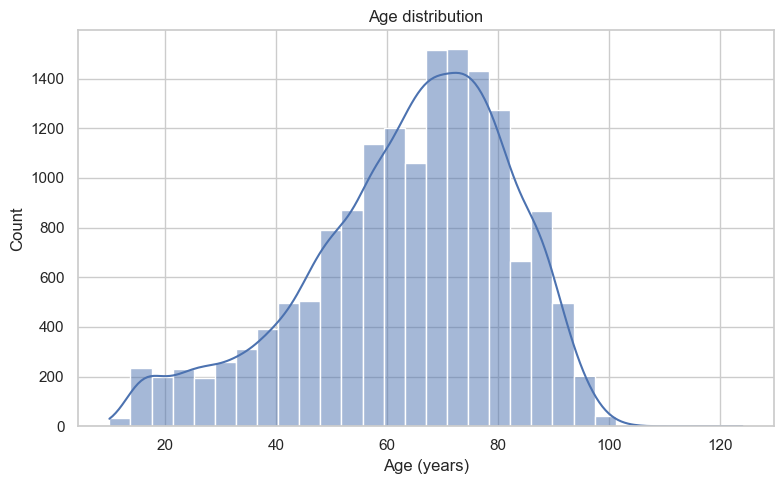

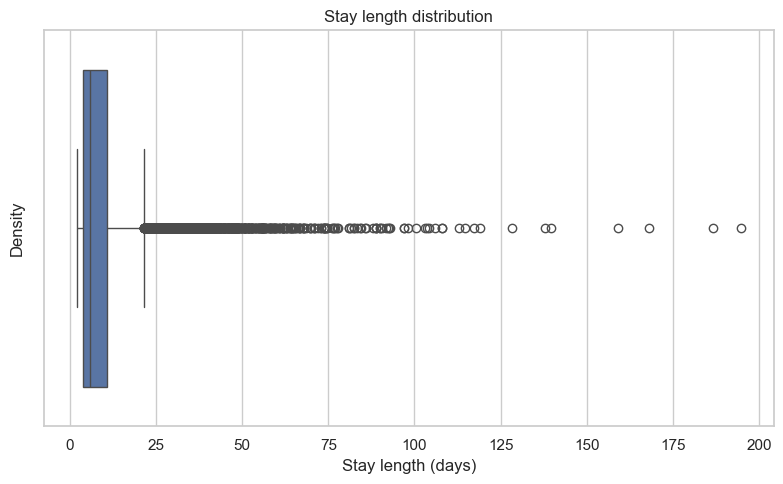

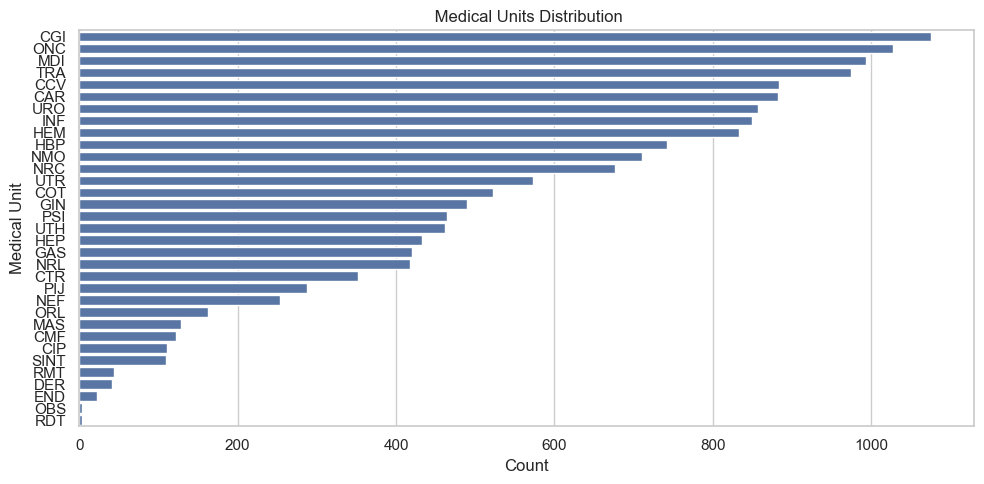

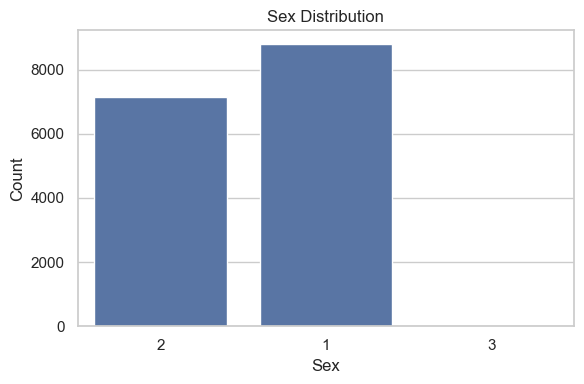

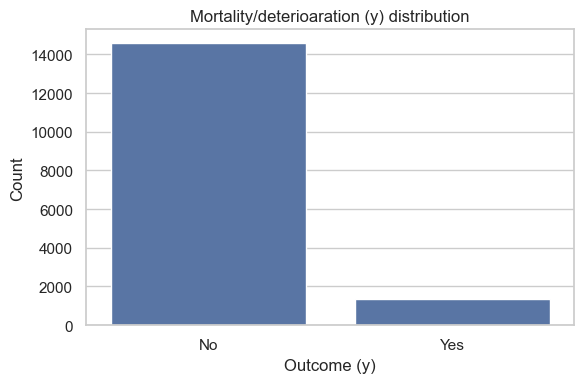

In [13]:
# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt







# --- Dfine variable lists and agragations
min_vars = ['PULSIOX', 'P_ART_S', 'LAB1314']
max_vars = ['TEMP', 'LAB2508', 'LAB2467', 'LAB1300', 'LAB2575','NEWS_2']
both_vars = ['FC', 'FR']
first_vars = ['age', 'stay_length', 'medical_unit','sex',]

# "sex" detection
sex_candidates = df[df['concept'].str.upper().isin(['SEX', 'SEXE', 'GENDER'])]['concept'].unique()
sex_concept = sex_candidates[0] if len(sex_candidates) > 0 else None
if sex_concept:
    first_vars.append(sex_concept)

# Force numeric conversion
numeric_concepts = set(min_vars + max_vars + both_vars + ['age', 'stay_length'])
df.loc[df['concept'].isin(numeric_concepts), 'value'] = pd.to_numeric(df.loc[df['concept'].isin(numeric_concepts), 'value'], errors='coerce')

# --- Agregacions ---
min_df = df[df['concept'].isin(min_vars)].groupby(['stay_id', 'concept'])['value'].min().unstack('concept').add_suffix('_min')
max_df = df[df['concept'].isin(max_vars)].groupby(['stay_id', 'concept'])['value'].max().unstack('concept').add_suffix('_max')
min_both_df = df[df['concept'].isin(both_vars)].groupby(['stay_id', 'concept'])['value'].min().unstack('concept').add_suffix('_min')
max_both_df = df[df['concept'].isin(both_vars)].groupby(['stay_id', 'concept'])['value'].max().unstack('concept').add_suffix('_max')
first_df = df[df['concept'].isin(first_vars)].groupby(['stay_id', 'concept'])['value'].max().unstack('concept')

# Outcome
y_df = df.groupby('stay_id')['y'].max()

# Final Merge 
agg_df = pd.concat([first_df, min_df, max_df, min_both_df, max_both_df, y_df.rename('y')], axis=1).reset_index()

# Transform stay length to days
agg_df['stay_length'] = pd.to_numeric(agg_df['stay_length'], errors='coerce') / 24



# --- Seaborn Figures ---
sns.set(style="whitegrid")

# 1. Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(agg_df['age'].dropna().astype(float), bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Stay length distribution


plt.figure(figsize=(8, 5))
sns.boxplot(x=agg_df['stay_length'].dropna().astype(float))
plt.title("Stay length distribution")
plt.xlabel("Stay length (days)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# 3. Medical unit distribution
plt.figure(figsize=(10, 5))
order = agg_df['medical_unit'].value_counts().index
sns.countplot(data=agg_df, y='medical_unit', order=order)
plt.title(" Medical Units Distribution")
plt.xlabel("Count")
plt.ylabel("Medical Unit")
plt.tight_layout()
plt.show()

# 4. Sex distribution
if sex_concept and sex_concept in agg_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=agg_df, x=sex_concept)
    plt.title("Sex Distribution")
    plt.xlabel("Sex")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 5. Outcome distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=agg_df, x='y')
plt.title("Mortality/deterioaration (y) distribution")
plt.xlabel("Outcome (y)")
plt.ylabel("Count")
plt.xticks([0,1], ['No', 'Yes'])
plt.tight_layout()
plt.show()






In [14]:

sex_counts = agg_df['sex'].value_counts(normalize=True)
outcome_counts = agg_df['y'].value_counts(normalize=True)
print(outcome_counts)
print(sex_counts)


y
0    0.914422
1    0.085578
Name: proportion, dtype: float64
sex
1    0.551830
2    0.448107
3    0.000063
Name: proportion, dtype: float64


## Variable Renaming
Rename laboratory variables with meaningful clinical names.

In [15]:
# Define the mapping for column renaming
lab_mapping = {
    'LAB1300_max': 'Leucocites_max',
    'LAB1314_min': 'Hemoglobin_min', 
    'LAB2467_max': 'Creatinine_max',
    'LAB2508_max': 'K_max',
    'LAB2575_max': 'PCR_max'
}

# Rename the columns
agg_df = agg_df.rename(columns=lab_mapping)

# Display the first few rows to verify changes
agg_df.head()

,stay_id,age,medical_unit,sex,stay_length,Hemoglobin_min,PULSIOX_min,P_ART_S_min,Leucocites_max,Creatinine_max,K_max,PCR_max,NEWS_2_max,TEMP_max,FC_min,FR_min,FC_max,FR_max,y
0,1,17.0,HBP,2,2.375000,NaN,93.0,90.0,NaN,NaN,NaN,NaN,4.0,36.9,64.0,10.0,87.0,20.0,0
1,3,83.0,TRA,1,34.458333,75.0,84.0,95.0,6.36,4.35,6.5,15.53,5.0,37.1,51.0,10.0,91.0,30.0,0
2,4,79.0,HEP,2,4.500000,101.0,92.0,87.0,17.28,2.3,5.7,6.71,10.0,36.3,66.0,18.0,83.0,28.0,0
3,5,62.0,NRC,1,3.500000,128.0,94.0,95.0,7.13,0.85,4.3,0.98,NaN,36.3,54.0,16.0,74.0,19.0,0
4,6,30.0,INF,1,9.458333,68.0,99.0,89.0,6.13,0.57,4.5,6.36,7.0,36.7,80.0,13.0,106.0,25.0,0


## Statistical Analysis

Perform statistical comparisons between patient groups (deterioration vs. no deterioration):
1. Calculate means by outcome group
2. Calculate percent differences 
3. Perform t-tests to assess statistical significance
4. Sort variables by their discriminative power

In [16]:
#
import pandas as pd
import numpy as np
from scipy import stats

# Ensure all numeric columns are properly typed and add statistical significance testing

numeric_columns = ['age', 'stay_length', 'Hemoglobin_min', 'PULSIOX_min', 'P_ART_S_min', 
                   'Leucocites_max', 'Creatinine_max', 'K_max', 'PCR_max', 'NEWS_2_max', 
                   'TEMP_max', 'FC_min', 'FR_min', 'FC_max', 'FR_max']

# Convert columns to numeric
for col in numeric_columns:
    if col in agg_df.columns:
        agg_df[col] = pd.to_numeric(agg_df[col], errors='coerce')

# Prepare results table with means by outcome
means_by_outcome = agg_df.groupby('y')[numeric_columns].mean().T.reset_index()
means_by_outcome.columns = ['Variable', 'No deterioration (y=0)', 'Deterioration (y=1)']

# Calculate percent difference
means_by_outcome['% Difference'] = ((means_by_outcome['Deterioration (y=1)'] - means_by_outcome['No deterioration (y=0)']) / 
                                   means_by_outcome['No deterioration (y=0)'] * 100).round(1)

# Add statistical significance testing
p_values = []
for var in numeric_columns:
    # Perform t-test between the two groups
    no_deterioration = agg_df[agg_df['y'] == 0][var].dropna()
    deterioration = agg_df[agg_df['y'] == 1][var].dropna()
    _, p_val = stats.ttest_ind(no_deterioration, deterioration, equal_var=False, nan_policy='omit')
    p_values.append(p_val)

# Add p-values to the table with significance markers
means_by_outcome['p-value'] = p_values
means_by_outcome['Significant'] = means_by_outcome['p-value'].apply(
    lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
)

# Format p-values for display
means_by_outcome['p-value'] = means_by_outcome['p-value'].apply(lambda p: f"{p:.4f}")

# Sort by absolute percent difference
means_by_outcome = means_by_outcome.sort_values(by='% Difference', key=abs, ascending=False)

# Display the table with p-values and significance markers
# drop the Index
means_by_outcome.reset_index(drop=True, inplace=True)


# Display the table
# Format numeric columns for better readability
for col in ['No deterioration (y=0)', 'Deterioration (y=1)', '% Difference']:
    means_by_outcome[col] = means_by_outcome[col].map(lambda x: f"{x:.2f}")

# Display the table without index

means_by_outcome[['Variable', 'No deterioration (y=0)', 'Deterioration (y=1)', '% Difference', 'p-value', 'Significant']]
means_by_outcome

,Variable,No deterioration (y=0),Deterioration (y=1),% Difference,p-value,Significant
0,NEWS_2_max,4.78,6.90,44.60,0.0000,***
1,PCR_max,9.79,13.51,38.10,0.0000,***
2,Creatinine_max,1.28,1.70,32.50,0.0000,***
3,Leucocites_max,9.66,12.46,29.00,0.0000,***
4,stay_length,9.16,11.29,23.20,0.0000,***
5,FC_max,96.46,107.95,11.90,0.0000,***
6,FR_max,23.00,25.52,11.00,0.0000,***
7,age,63.38,69.10,9.00,0.0000,***
8,P_ART_S_min,97.55,89.57,-8.20,0.0000,***
9,Hemoglobin_min,107.59,99.49,-7.50,0.0000,***


## Medical Unit Analysis

Analyze deterioration rates by medical unit to identify high-risk areas:
1. Calculate the percentage of deterioration cases by medical unit
2. Visualize using bar charts
3. Compare with the overall deterioration rate
4. Show both relative percentages and absolute counts

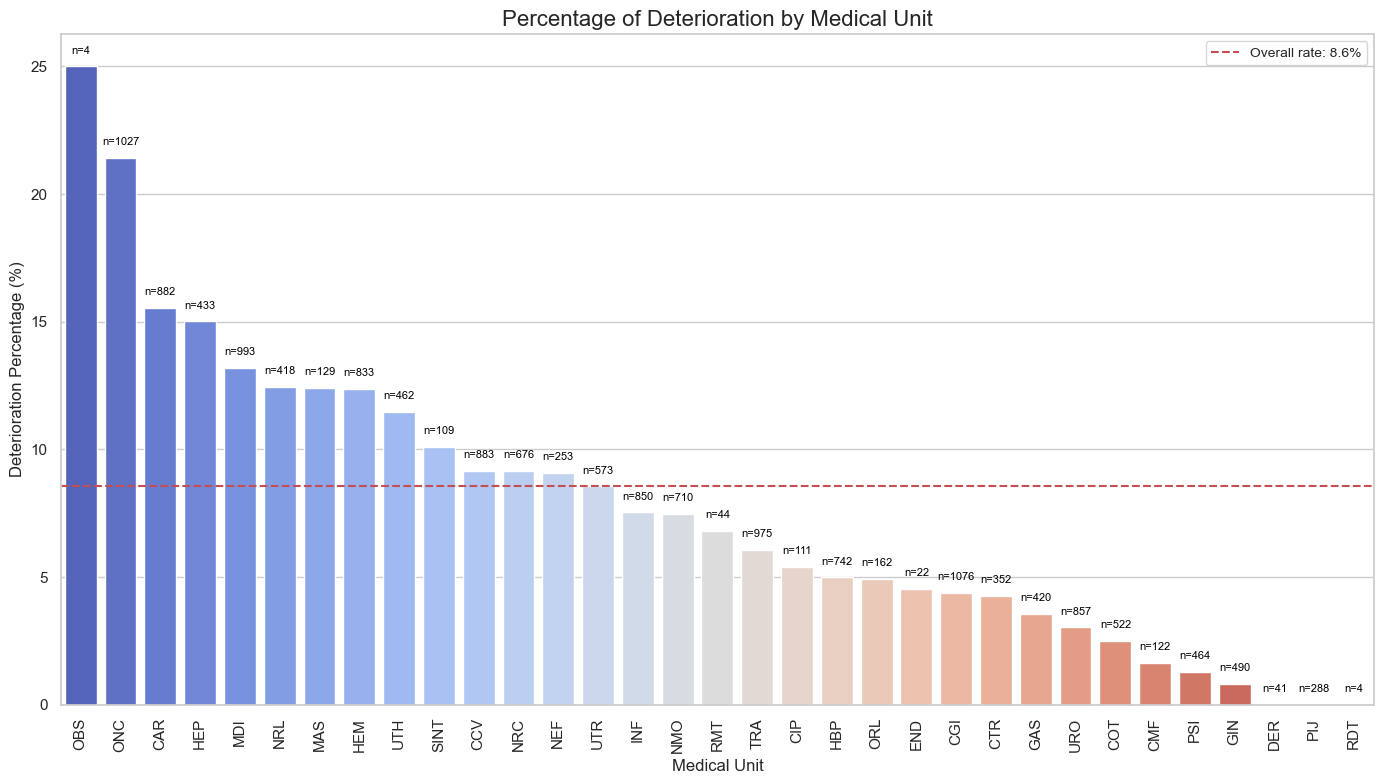

<Figure size 1400x800 with 0 Axes>

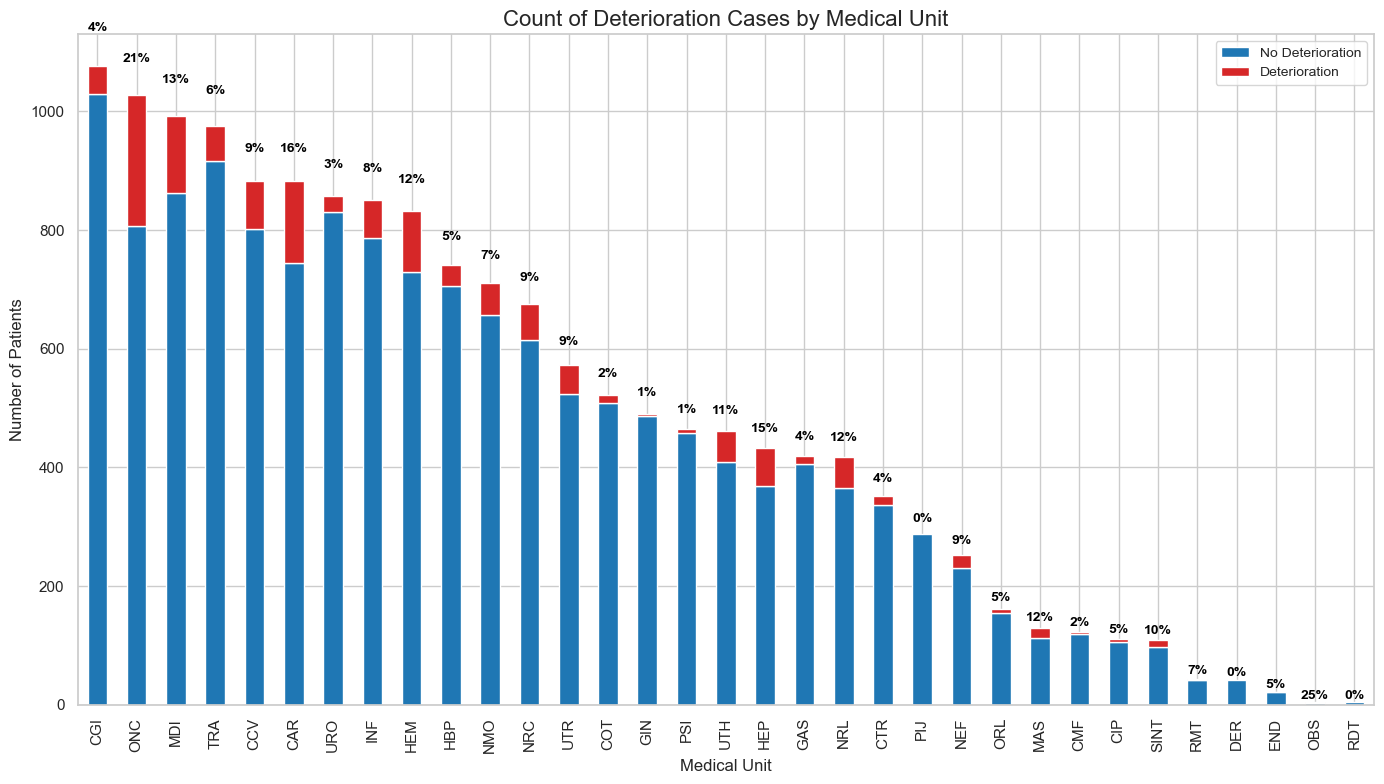

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Group by medical_unit and calculate deterioration percentage
deterioration_by_unit = agg_df.groupby('medical_unit')['y'].agg(['count', 'mean']).reset_index()
deterioration_by_unit.columns = ['medical_unit', 'patient_count', 'deterioration_rate']
deterioration_by_unit['deterioration_percentage'] = deterioration_by_unit['deterioration_rate'] * 100

# Sort by deterioration rate for better visualization
deterioration_by_unit = deterioration_by_unit.sort_values('deterioration_percentage', ascending=False)

# Create visualization for percentages
plt.figure(figsize=(14, 8))

# Plot percentage of deterioration by medical unit
ax = sns.barplot(x='medical_unit', y='deterioration_percentage', data=deterioration_by_unit, palette='coolwarm')

# Add count of patients for each unit as text
for i, row in enumerate(deterioration_by_unit.itertuples()):
    ax.text(i, row.deterioration_percentage + 0.5, f'n={row.patient_count}', ha='center', rotation=0, color='black', fontsize=8)

# Set labels and title
plt.title('Percentage of Deterioration by Medical Unit', fontsize=16)
plt.xlabel('Medical Unit', fontsize=12)
plt.ylabel('Deterioration Percentage (%)', fontsize=12)
plt.xticks(rotation=90)

# Add a horizontal line for the overall deterioration rate
overall_rate = agg_df['y'].mean() * 100
plt.axhline(y=overall_rate, color='r', linestyle='--', label=f'Overall rate: {overall_rate:.1f}%')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Create a stacked bar chart showing absolute counts
plt.figure(figsize=(14, 8))

# Calculate counts
unit_outcomes = pd.crosstab(agg_df['medical_unit'], agg_df['y'])
unit_outcomes.columns = ['No Deterioration', 'Deterioration']
unit_outcomes = unit_outcomes.reset_index()

# Sort by deterioration rate
unit_outcomes = unit_outcomes.merge(
    deterioration_by_unit[['medical_unit', 'deterioration_percentage']], 
    on='medical_unit'
)
unit_outcomes = unit_outcomes.sort_values('deterioration_percentage', ascending=False)

# Add total patient count column
unit_outcomes['Total'] = unit_outcomes['No Deterioration'] + unit_outcomes['Deterioration']

# Sort by total number of patients in descending order
unit_outcomes = unit_outcomes.sort_values('Total', ascending=False)

# Plot stacked bars
ax = unit_outcomes.plot(
    x='medical_unit', 
    y=['No Deterioration', 'Deterioration'], 
    kind='bar', 
    stacked=True,
    figsize=(14, 8),
    color=['#1f77b4', '#d62728']
)

# Rename column to handle spaces before using itertuples
unit_outcomes = unit_outcomes.rename(columns={'No Deterioration': 'No_Deterioration'})

# Add percentage text on bars
for i, row in enumerate(unit_outcomes.itertuples()):
    total = row.No_Deterioration + row.Deterioration
    percentage = row.deterioration_percentage
    if total > 0:
        y_pos = total + total * 0.05  # position text slightly above the bar
        ax.text(i, y_pos, f'{percentage:.0f}%', ha='center', va='bottom', 
                color='black', fontweight='bold', fontsize=10)

plt.title('Count of Deterioration Cases by Medical Unit', fontsize=16)
plt.xlabel('Medical Unit', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=90)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

## NEWS-2 Score Evaluation

NEWS-2 ≥ 5 is the current method to activate the Rapid Response Team. We will use it as a baseline prediction of clinical deterioaration. 
Evaluate the performance of the National Early Warning Score 2 (NEWS-2) as a predictor of deterioration:
1. Create a binary classification using NEWS-2 ≥ 5 as threshold
2. Calculate performance metrics (accuracy, precision, recall, etc.)
3. Generate a classification report

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a binary column for NEWS_2_max: 0 if <5, 1 if >=5
agg_df['news_2_cat'] = agg_df['NEWS_2_max'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate performance metrics
accuracy = accuracy_score(agg_df['y'], agg_df['news_2_cat'])
precision = precision_score(agg_df['y'], agg_df['news_2_cat'])
recall = recall_score(agg_df['y'], agg_df['news_2_cat'])
f1 = f1_score(agg_df['y'], agg_df['news_2_cat'])

# Additional metrics
roc_auc = roc_auc_score(agg_df['y'], agg_df['news_2_cat'])
avg_precision = average_precision_score(agg_df['y'], agg_df['news_2_cat'])

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

print("\nClassification Report:")
print(classification_report(agg_df['y'], agg_df['news_2_cat']))


Metrics:
Accuracy: 0.6212
Precision: 0.1116
Recall: 0.4923
F1 Score: 0.1820
ROC AUC: 0.5628
Average Precision: 0.0984

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     14564
           1       0.11      0.49      0.18      1363

    accuracy                           0.62     15927
   macro avg       0.52      0.56      0.47     15927
weighted avg       0.86      0.62      0.70     15927



## Missing Data Analysis

Analyze and visualize missing data patterns in the dataset to assess data quality and completeness.

In [19]:
# Pivot to wide format, resolving duplicates by taking the max value
df_wide = df.pivot_table(index=['stay_id'], columns='concept', values='value', aggfunc='max').reset_index()
# Drop specified columns
df_wide_2 = df_wide.drop(columns=['stay_id', 'stay_length', 'medical_unit','NEWS_2',])
# Rename columns for clarity using a dictionary
df_wide_2 = df_wide_2.rename(columns={
    'LAB1300': 'Leucocites',
    'LAB1314': 'Hemoglobin', 
    'LAB2467': 'Creatinine',
    'LAB2508': 'K',
    'LAB2575': 'PCR'
})

# Display the wide format DataFrame
df_wide_2.head()


concept,CAR_RITM,EPOC,ESTADO_CONCIENC,FC,FR,Leucocites,Hemoglobin,Creatinine,K,PCR,O2_DIS,PULSIOX,P_ART_S,TEMP,age,sex
0,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,87.0,20.0,NaN,NaN,NaN,NaN,NaN,O2_DIS_6,99.0,117.0,36.9,17.0,2
1,NaN,EPOC_4,ESTADO_CONCIENC_4,91.0,30.0,6.36,103.0,4.35,6.5,15.53,O2_DIS_6,99.0,172.0,37.1,83.0,1
2,NaN,EPOC_4,ESTADO_CONCIENC_1,83.0,28.0,17.28,108.0,2.3,5.7,6.71,O2_DIS_6,98.0,161.0,36.3,79.0,2
3,NaN,NaN,ESTADO_CONCIENC_1,74.0,19.0,7.13,128.0,0.85,4.3,0.98,O2_DIS_6,97.0,145.0,36.3,62.0,1
4,NaN,EPOC_4,ESTADO_CONCIENC_1,106.0,25.0,6.13,80.0,0.57,4.5,6.36,O2_DIS_6,99.0,114.0,36.7,30.0,1


<Figure size 1200x600 with 0 Axes>

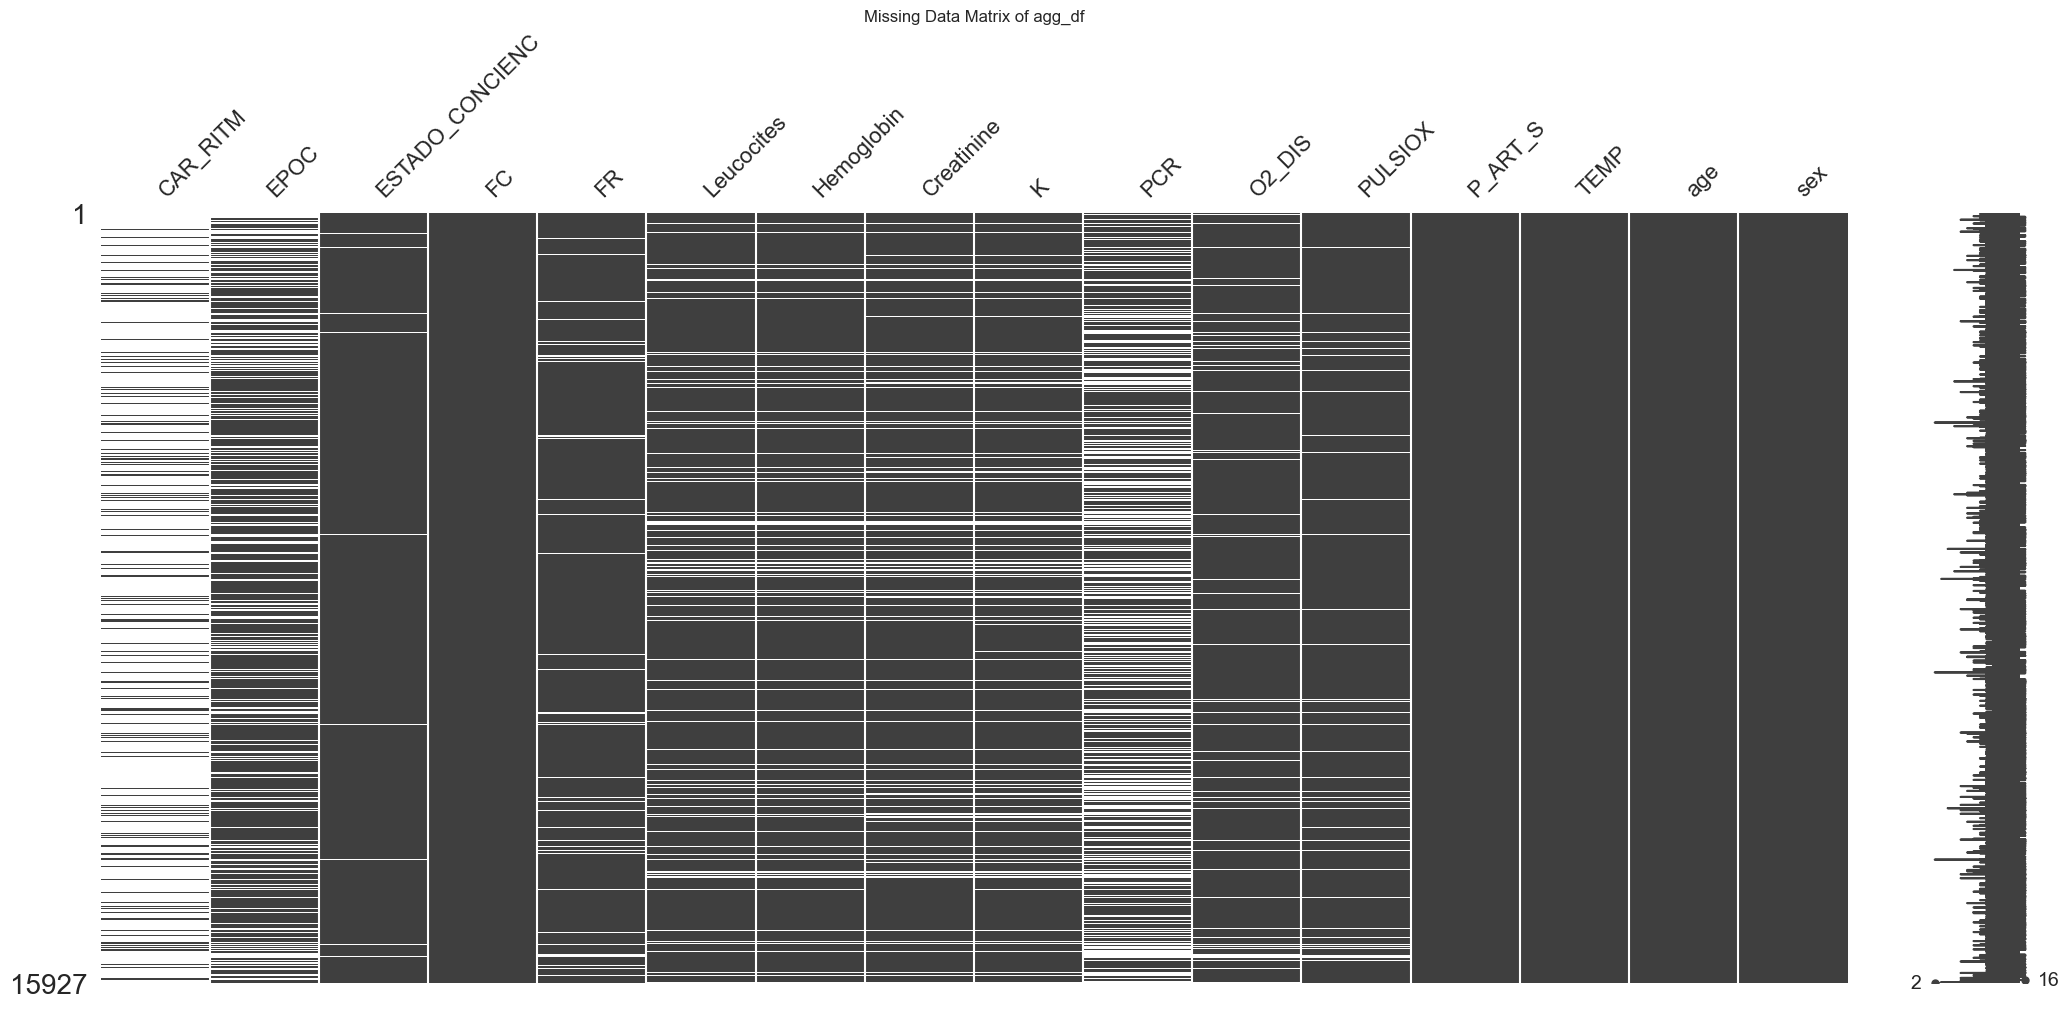

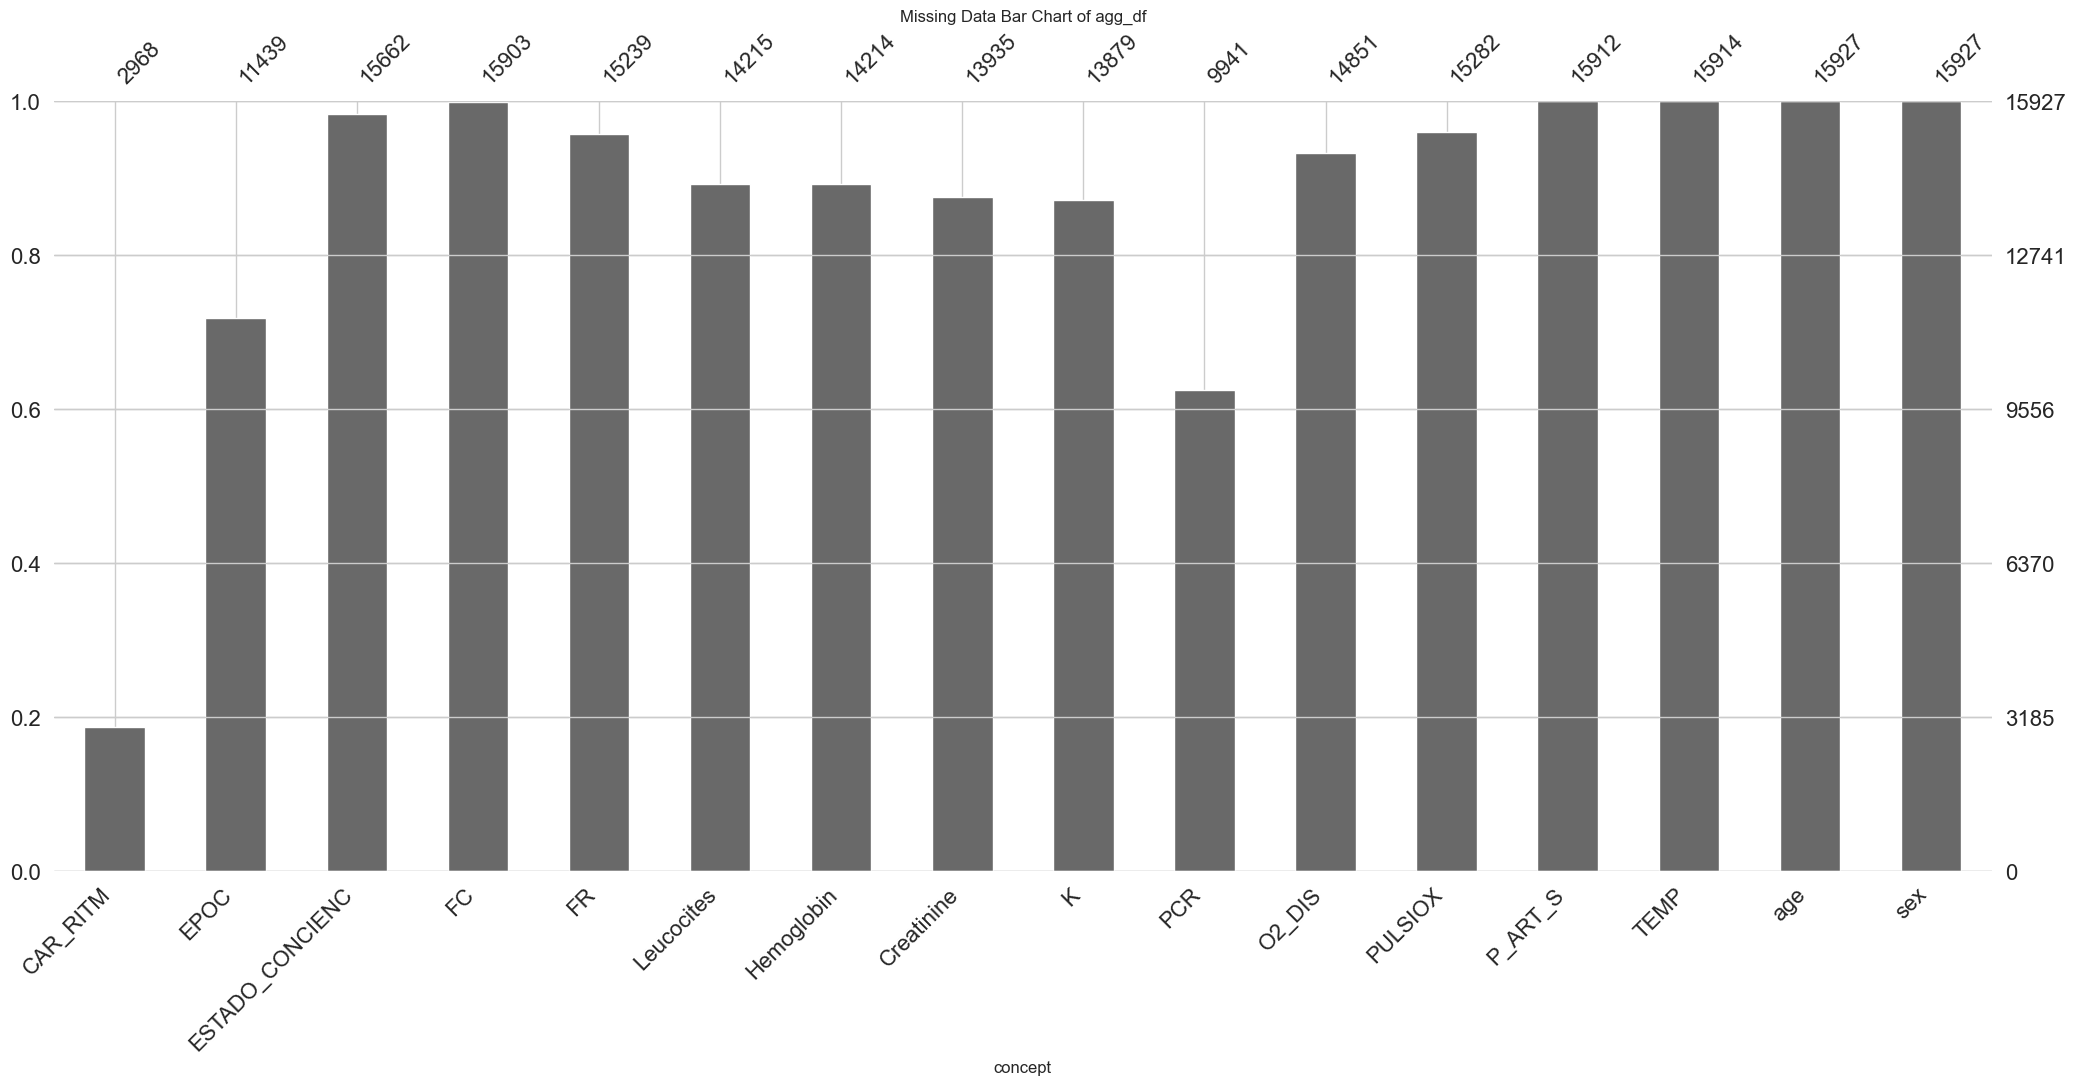

In [20]:
import missingno as msno

import matplotlib.pyplot as plt

# Matriu de missing values
plt.figure(figsize=(12, 6))
msno.matrix(df_wide_2)
plt.title("Missing Data Matrix of agg_df")
plt.show()

# Bar plot dels missing values
plt.figure(figsize=(12, 6))
msno.bar(df_wide_2)
plt.title("Missing Data Bar Chart of agg_df")
plt.show()